In [1]:
from matplotlib.tri import Triangulation
import numpy as np
import argparse
import torch
import torch.nn as nn
from pina.model.layers import PODBlock, RBFBlock
from pina.model import FeedForward
from pina.callbacks import MetricTracker
from pina import Condition, LabelTensor, Trainer, Plotter
from pina.loss import LpLoss
import matplotlib
import matplotlib.pyplot as plt
from pod_rbf import err, PODRBF
from corrected_rom import CorrectedROM
from utils import plot, compute_exact_correction
from quadnet import QuadNet
import os
from pytorch_lightning.callbacks import Callback
import logging
import time
from setup_cavity import CavityProblem
from scipy.stats import gaussian_kde

In [5]:
class InterpNN(nn.Module):
    def __init__(self,reddim):
        super().__init__()
        self.reddim = reddim
        self.nn = FeedForward(input_dimensions=1,
                                output_dimensions=reddim,
                                layers=[10,10],
                                func=nn.Sigmoid)
    def forward(self,par):
        return self.nn(par)

In [14]:
field = "mag(v)"
reddim = 3
bigdim = 15
epochs = 200

cavity = CavityProblem(field,reddim,subset=None,test_size=100,train_size=200,device='cpu')

problem = cavity.problem

# 2. POD + DeepONet modes@coeffs
corr_net = QuadNet(cavity.modes, cavity.coords)
# coef = cavity.pod.reduce(cavity.snapshots_train)

id_ = 1256
# epochs = 20000
num_batches = 1

data = cavity.data
params_train = cavity.params_train
params_test = cavity.params_test
snapshots_train = cavity.snapshots_train
snapshots_test = cavity.snapshots_test
pod = cavity.pod

rom = CorrectedROM.load_from_checkpoint(
        checkpoint_path=os.path.join("./",
        f'lightning_logs/version_{id_}/checkpoints/epoch={epochs-1}-step={epochs*num_batches}.ckpt'),
        problem = problem,
       reduction_network = cavity.pod,
       interpolation_network = cavity.rbf,
       correction_network = corr_net)
rom.cpu()
#interp = torch.load('./interp_net_params_many')

# fit the pod and RBF on train data
# rom.neural_net["reduction_network"].fit(snapshots_train)
# rom.neural_net["interpolation_network"].fit(params_train,
#                                        rom.neural_net["reduction_network"].reduce(snapshots_train))
rom.eval()
print('ok!')

ok!


In [15]:
# Evaluate the ROM on train and test
predicted_snaps_train = rom(params_train)
predicted_snaps_test = rom(params_test)
# train_error = err(snapshots_train, predicted_snaps_train)
# test_error = err(snapshots_test, predicted_snaps_test)
train_error = (torch.linalg.norm(predicted_snaps_train-snapshots_train,dim=-1)/torch.linalg.norm(snapshots_train,dim=-1)).tensor.cpu().detach().numpy()
test_error = (torch.linalg.norm(predicted_snaps_test-snapshots_test,dim=-1)/torch.linalg.norm(snapshots_test,dim=-1)).tensor.cpu().detach().numpy()
# np.save('./full_data/backstep/train_error_mu',train_error)
# np.save('./full_data/backstep/test_error_mu',test_error)
print('train',train_error.mean(),train_error.std())
print('test',test_error.mean(),test_error.std())
#exit()

train 0.092076495 0.09813312
test 0.10661568 0.10802987


In [8]:
pod_pred_train = pod.expand(cavity.rbf(params_train))
pod_pred_test = pod.expand(cavity.rbf(params_test))

# pod_train_error = err(snapshots_train, pod_pred_train)
# pod_test_error = err(snapshots_test, pod_pred_test)
pod_train_error = (torch.linalg.norm(pod_pred_train-snapshots_train,dim=-1)/torch.linalg.norm(snapshots_train,dim=-1)).tensor.cpu().detach().numpy()
pod_test_error = (torch.linalg.norm(pod_pred_test-snapshots_test,dim=-1)/torch.linalg.norm(snapshots_test,dim=-1)).tensor.cpu().detach().numpy()

# np.save('./full_data/backstep/pod_train_error',pod_train_error)
# np.save('./full_data/backstep/pod_test_error',pod_test_error)


print('train',pod_train_error.mean(),pod_train_error.std())
print('test',pod_test_error.mean(),pod_test_error.std())


train 0.09252699 0.09848712
test 0.10751245 0.109530754


In [126]:
rom.neural_net['interpolation_network'] = interp
print(rom.neural_net['interpolation_network'])
print('NN interpolation: ',err(snapshots_test,pod.expand(interp(params_test))))

rom.neural_net['interpolation_network'] = cavity.rbf
print(rom.neural_net['interpolation_network'])
print('RBF interpolation: ',err(snapshots_test,pod.expand(cavity.rbf(params_test))))

InterpNN(
  (nn): FeedForward(
    (model): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=10, out_features=9, bias=True)
    )
  )
)
NN interpolation:  (0.056178122758865356, 0.032365161925554276)
RBFBlock()
RBF interpolation:  (0.05538247153162956, 0.0317532904446125)


In [127]:
print('nn error: ',err(pod.reduce(snapshots_test),interp(params_test)))
print('rbf error: ',err(pod.reduce(snapshots_test),cavity.rbf(params_test)))

nn error:  (0.10540107637643814, 0.0725359320640564)
rbf error:  (0.11455906182527542, 0.0061270142905414104)


In [19]:
corr_net.C(cavity.params_test)[0]

LabelTensor([[[-0.0009, -0.0006,  0.0005,  0.0005,  0.0004,  0.0002]]],
            grad_fn=<AliasBackward0>)

In [16]:
param_noise = (torch.randn(params_test.shape) * 1e-1)
coeff = cavity.rbf(params_train)
coeff_norm = torch.linalg.norm(coeff,dim=1)
correction = corr_net(params_train,coeff)
correction_pert = corr_net(params_test+param_noise,cavity.rbf(params_test+param_noise))

In [112]:
params_train

LabelTensor([[[0.7625]],
             [[0.2308]],
             [[0.1037]],
             [[0.6120]],
             [[0.8863]],
             [[0.7525]],
             [[0.4682]],
             [[0.0602]],
             [[0.6054]],
             [[0.3211]]])

In [120]:
for i in (0,2,3,4):
    print(exact_correction[i],params_test[i])

no labels
LabelTensor([[[-4.0993e-09,  6.2849e-09,  1.0424e-09,  ..., -2.9567e-03,
               -2.9567e-03, -1.4784e-03]]], grad_fn=<AliasBackward0>) labels(['mu'])
LabelTensor([[[0.6789]]])
no labels
LabelTensor([[[ 9.4369e-10,  5.7305e-09, -2.7081e-09,  ..., -8.9973e-05,
               -8.9973e-05, -4.4987e-05]]], grad_fn=<AliasBackward0>) labels(['mu'])
LabelTensor([[[0.5084]]])
no labels
LabelTensor([[[-1.4289e-09, -6.5552e-09,  5.5984e-10,  ..., -6.2651e-03,
               -6.2651e-03, -3.1326e-03]]], grad_fn=<AliasBackward0>) labels(['mu'])
LabelTensor([[[0.0301]]])
no labels
LabelTensor([[[ 4.5545e-09, -4.5958e-09, -2.0267e-09,  ..., -8.6188e-05,
               -8.6188e-05, -4.3094e-05]]], grad_fn=<AliasBackward0>) labels(['mu'])
LabelTensor([[[0.7793]]])


In [118]:
exact_correction = snapshots_train - pod.expand(interp(params_train))

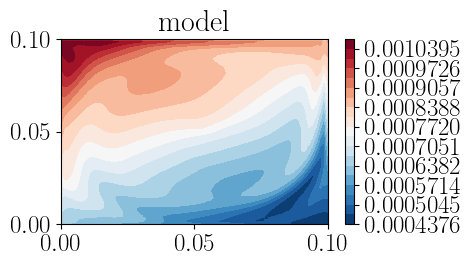

In [17]:
list_fields = [correction[0].detach().numpy().reshape(-1)]#,exact_correction[0].detach().numpy().reshape(-1)]
vmin = min([field.min() for field in list_fields])
vmax = max([field.max() for field in list_fields])
plot(cavity.data.triang,list_fields,['model','real'],vmin=vmin,vmax=vmax)

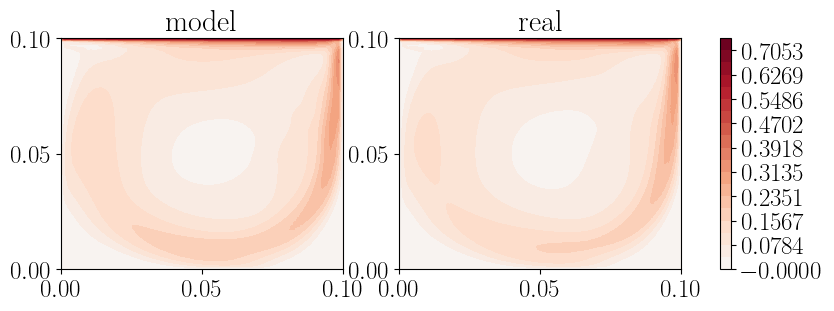

In [104]:
# rom.neural_net['interpolation_network'] = interp
pred = rom(params_test)
pred_pod = pod.expand(interp(params_test))
list_fields = [pred_pod[0].detach().numpy().reshape(-1),snapshots_test[0].detach().numpy().reshape(-1)]
vmin = min([field.min() for field in list_fields])
vmax = max([field.max() for field in list_fields])
plot(cavity.data.triang,list_fields,['model','real'],vmin=vmin,vmax=vmax)

In [84]:
torch.linalg.norm(correction_pert)/torch.linalg.norm(correction)

LabelTensor(1.1611, grad_fn=<AliasBackward0>)

In [59]:
correction.shape

torch.Size([100, 5041])

In [49]:
c1.shape

torch.Size([45])

In [7]:
corr_net.C(params_test).min()

LabelTensor(-0.3495, device='cuda:0', grad_fn=<AliasBackward0>)

no labels
LabelTensor([[[-0.0394,  0.1200, -0.1048,  0.1184, -0.1435,  0.0629]],
             [[ 0.0094, -0.0364,  0.0159, -0.0317,  0.0247, -0.0196]],
             [[ 0.0192, -0.0751,  0.0413, -0.0516,  0.0539, -0.0390]]],
            grad_fn=<AliasBackward0>)
no labels
LabelTensor([[[ 0.0092, -0.0198, -0.0754, -0.0236, -0.0491,  0.0003]],
             [[ 0.0010, -0.0065,  0.0022, -0.0017,  0.0018, -0.0032]],
             [[ 0.0072, -0.0350, -0.0039, -0.0234,  0.0121, -0.0021]]],
            grad_fn=<AliasBackward0>)
no labels
LabelTensor([[[ 0.0021, -0.0121,  0.0071, -0.0087,  0.0105,  0.0044]],
             [[-0.0033,  0.0239, -0.0257,  0.0290, -0.0459, -0.0135]],
             [[-0.0073,  0.0855, -0.0774,  0.0372, -0.1079,  0.0018]]],
            grad_fn=<AliasBackward0>)
no labels
LabelTensor([[[-0.0453,  0.1210, -0.0501,  0.1424, -0.1254,  0.0700]],
             [[ 0.0064, -0.0336, -0.0048, -0.0354,  0.0193, -0.0183]],
             [[ 0.0151, -0.0926, -0.0334, -0.0954,  0.0260,  0

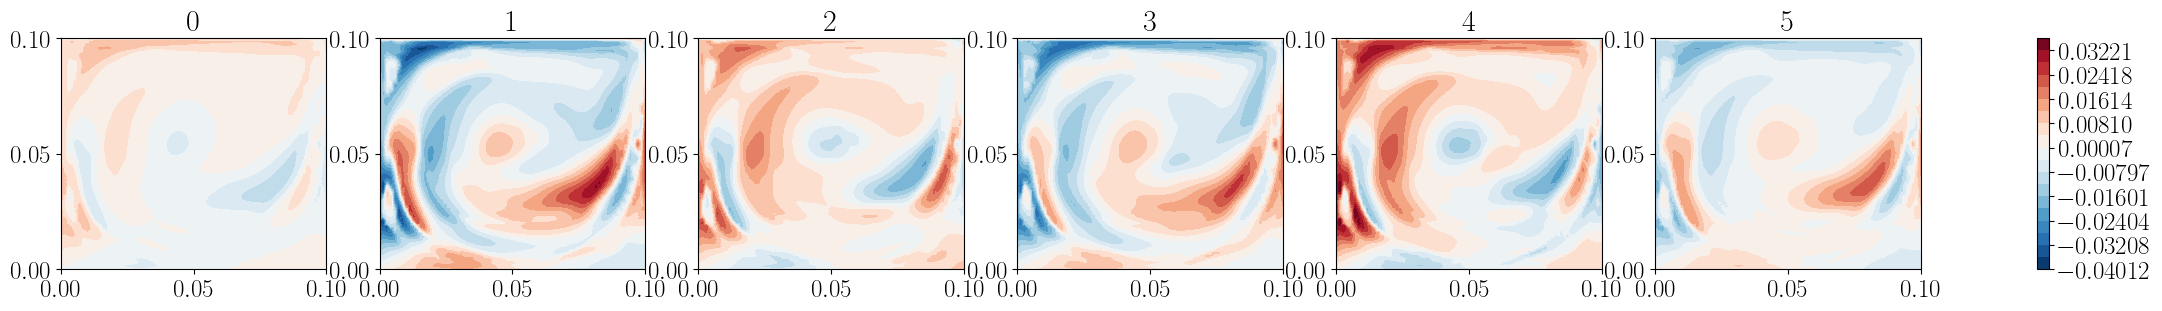

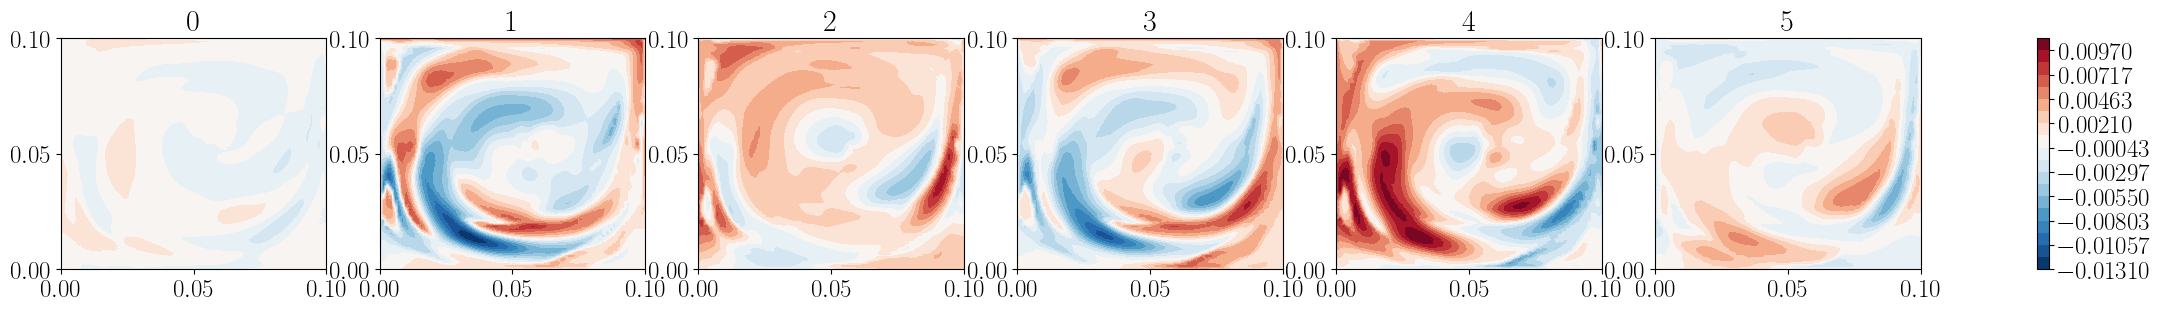

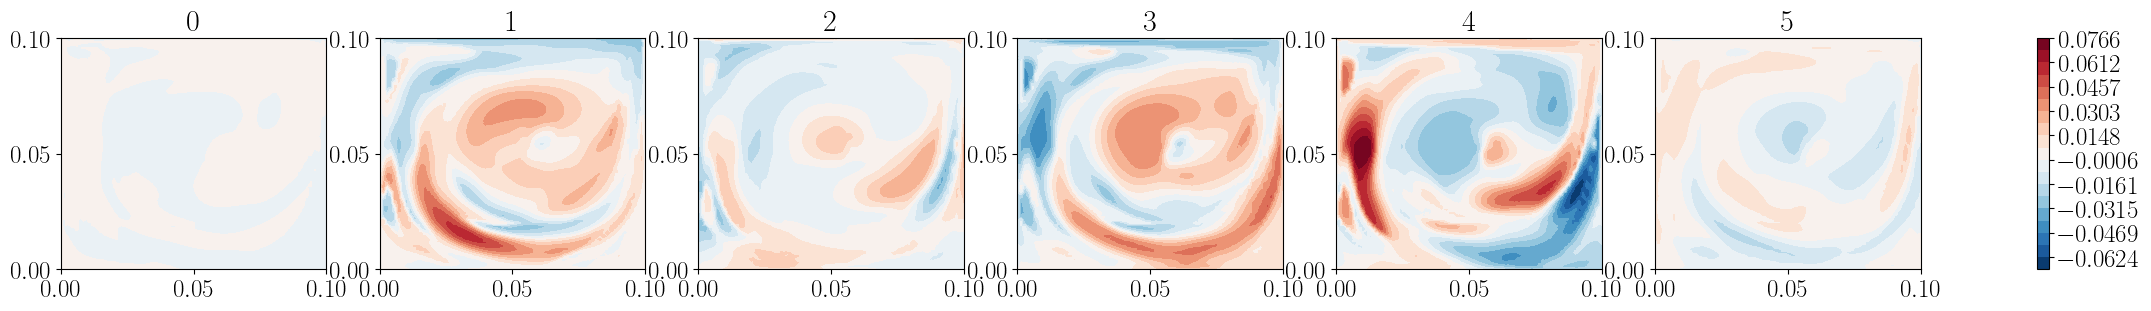

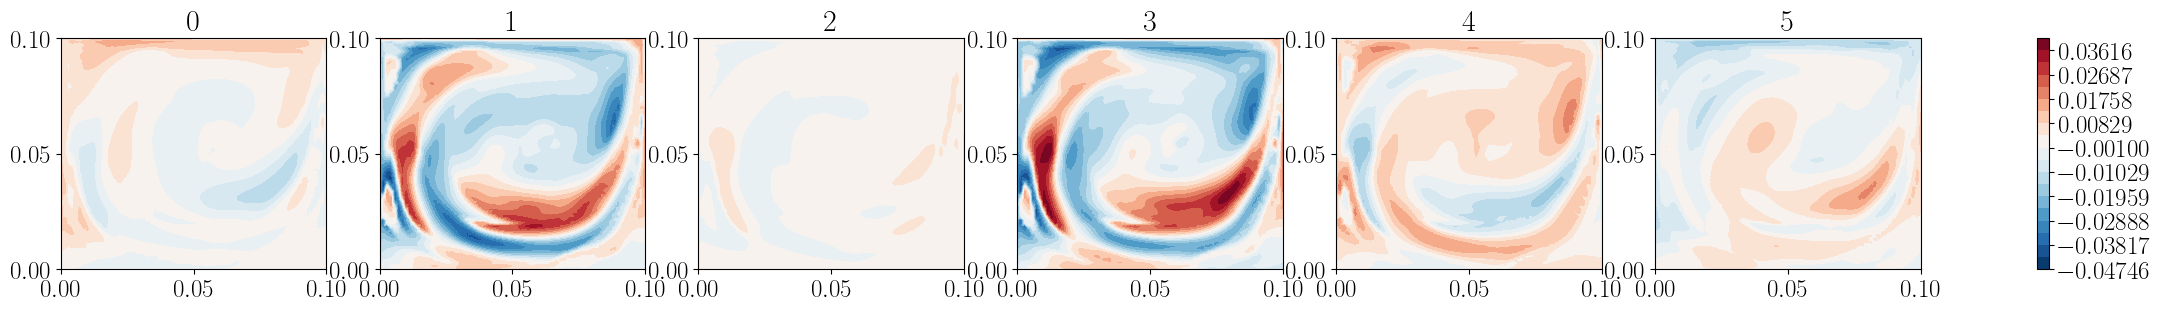

In [126]:
#print(torch.min(rom.problem.conditions["correction"].output_points))
#print(torch.max(rom.problem.conditions["correction"].output_points))
#print(rom.modes@corr_net.C())

mus = torch.tensor([0.2,0.4,0.6,0.8])[:,None]

for i in range(4):
    cs = corr_net.C(mus).tensor
    c = cs[i,...]
    print(rom.modes@c)
    list_labels = [f'{i}' for i in range(0,reddim*(reddim+1)//2)]
    list_fields = [c[:,i].detach().numpy().reshape(-1) for i in range(0,reddim*(reddim+1)//2)]
    vmin = min([field.min() for field in list_fields])
    vmax = max([field.max() for field in list_fields])
    plot(data.triang,list_fields,list_labels,
             filename=f'img/c_entries_net_mu{mus[i].item():.2f}.png',
             vmin = vmin,
             vmax = vmax)

NameError: name 'list_fields' is not defined

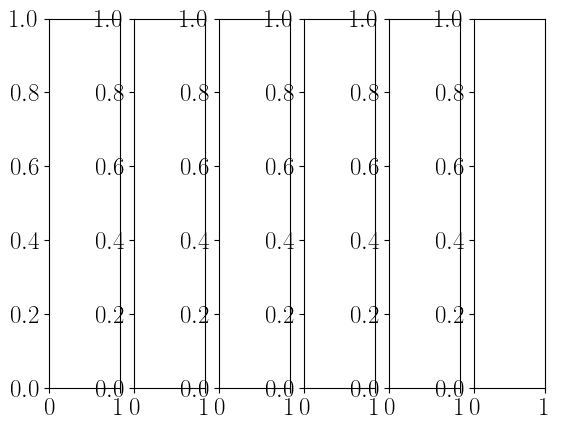

In [11]:
fig,axs = plt.subplots(1,6)
axs = axs.ravel()
x = np.linspace(-0.02,0.02,200)
for i,field in enumerate(list_fields):
        ax = axs[i]
        # ax = fig.add_subplot(1,6,1+i)
        # pos = poss[i]
        # ax = fig.add_axes([pos.x0, pos.y0, pos.width , 0.3])
        dens = gaussian_kde(field)
        ax.plot(x,dens(x),'k')
        ax.fill_between(x,np.zeros_like(x),dens(x),color='grey',alpha=0.6)
        ax.set_title(f'Column {i}')
        ax.set_xlabel('$|v|$')
axs[0].set_ylabel('Density')
fig.tight_layout()
plt.show()


# Plot the modes with the same function
#modes = rom.neural_net["correction_network"].modes
#modes = modes.detach().numpy()
#list_fields = [modes[:, i] for i in range(modes.shape[1])]
#list_labels = [f'Mode {i}' for i in range(modes.shape[1])]
##plot(data.triang,list_fields, list_labels, filename='img/transformed_modes_10kepochs')
#for i in range(reddim):
#    list_fields = [modes[:, i].reshape(-1)]
#    #list_fields = [modes.detach().numpy()[:, i].reshape(-1)
#    #        for i in range(reddim)]
#    list_labels = [f'Corrected mode {i+1}']# for i in range(reddim)]
#    plot(data.triang,list_fields, list_labels,filename=f'img/modes{i+1}_deep_sparse')
##exit()


# Evaluate the ROM on train and test
predicted_snaps_train = rom(params_train)
predicted_snaps_test = rom(params_test)
print(params_test[10])
#np.save('deep_prediction_10',predicted_snaps_test[10].detach().numpy())
train_error = err(snapshots_train, predicted_snaps_train)
test_error = err(snapshots_test, predicted_snaps_test)
#print('Train error = ', err(snapshots_train, predicted_snaps_train))
#print('Test error = ', err(snapshots_test, predicted_snaps_test))
print(train_error,test_error)
#exit()

# Plot the test results (POD-RBF and POD-RBF corrected)
ind_test = 2
snap = snapshots_test[ind_test].detach().numpy().reshape(-1)
pred_snap = predicted_snaps_test[ind_test].detach().numpy().reshape(-1)
# POD-RBF (fit and predict)
pod_rbf = PODRBF(pod_rank=reddim, rbf_kernel='thin_plate_spline')
pod_rbf.fit(params_train, snapshots_train)
pred_pod_rbf = pod_rbf(params_test).detach().numpy()[ind_test].reshape(-1)
list_fields = [snap, pred_snap, pred_pod_rbf,
        snap - pred_snap, snap-pred_pod_rbf]
list_labels = ['Truth', 'Corrected POD-RBF', 'POD',
        'Error Corrected', 'Error POD']
plot(data.triang,list_fields, list_labels, filename='img/quadnet_compare')

# Plot test correction (approximated and exact)
coeff_orig = rom.neural_net["interpolation_network"](params_test)
corr_scaler = rom.neural_net["correction_network"].scaler
# scale the predicted correction back to original scale
corr = corr_net(params_test,coeff_orig)
#if corr_scaler is not None:
#    corr = corr_scaler.inverse_transform(corr)
corr = corr.detach().numpy()[ind_test, :].reshape(-1)
exact_corr = compute_exact_correction(pod, snapshots_test)
if corr_scaler is not None:
    exact_corr = corr_scaler.transform(exact_corr)
exact_corr = exact_corr[ind_test].detach().numpy().reshape(-1)
list_fields = [corr, exact_corr, corr - exact_corr]
list_labels = ['Approximated Correction', 'Exact Correction', 'Error']
plot(data.triang,list_fields, list_labels, filename='img/quadnet_correction')

no labels
LabelTensor(0.0470, grad_fn=<AliasBackward0>) no labels
LabelTensor(0.0446, grad_fn=<AliasBackward0>)


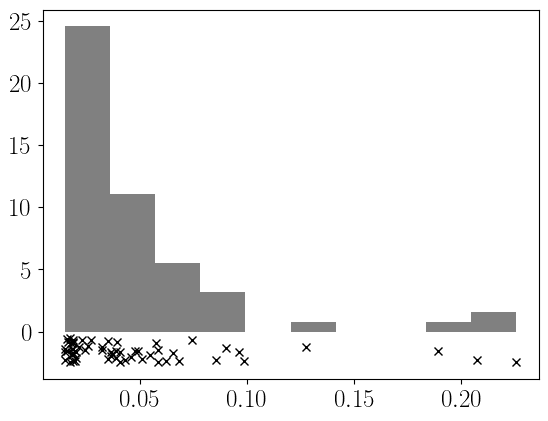

In [131]:
e = torch.norm(snapshots_test - predicted_snaps_test,dim=-1)/torch.norm(snapshots_test,dim=-1)
print(e.mean(),e.std())
fig,ax = plt.subplots()
ax.hist(e.detach().numpy(),density=True,color='grey')
ax.plot(e.detach().numpy(),-2.5+np.random.rand(len(e))*2,'xk')

In [40]:
corrections.shape

(240, 5041)

In [42]:
np.mean(np.linalg.norm(corrections,axis=1))

0.36818597

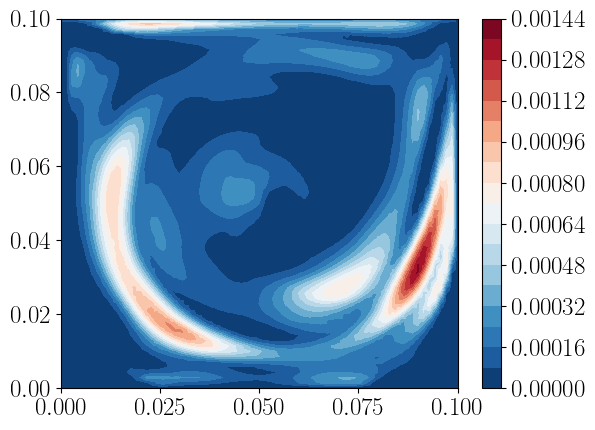

In [48]:
triangulation = data.triang
corrections = cavity.exact_correction.detach().numpy()
#p = np.exp(-np.mean(avg)/(avg+1e-6))
# p = np.exp(-np.mean(np.abs(corrections))/(np.mean(np.abs(corrections),axis=0)+1e-6)) #+ 1/1639
p = np.exp(-np.mean(np.max(np.abs(corrections),axis=1))/(np.mean(np.abs(corrections),axis=0)+1e-6)) #+ 1/1639
p /= np.sum(p)
tp = plt.tricontourf(triangulation,p,levels=20)
plt.colorbar(tp)
# plt.gcf().savefig("quadnet/cavity_all_20_pts_p/probability_density")

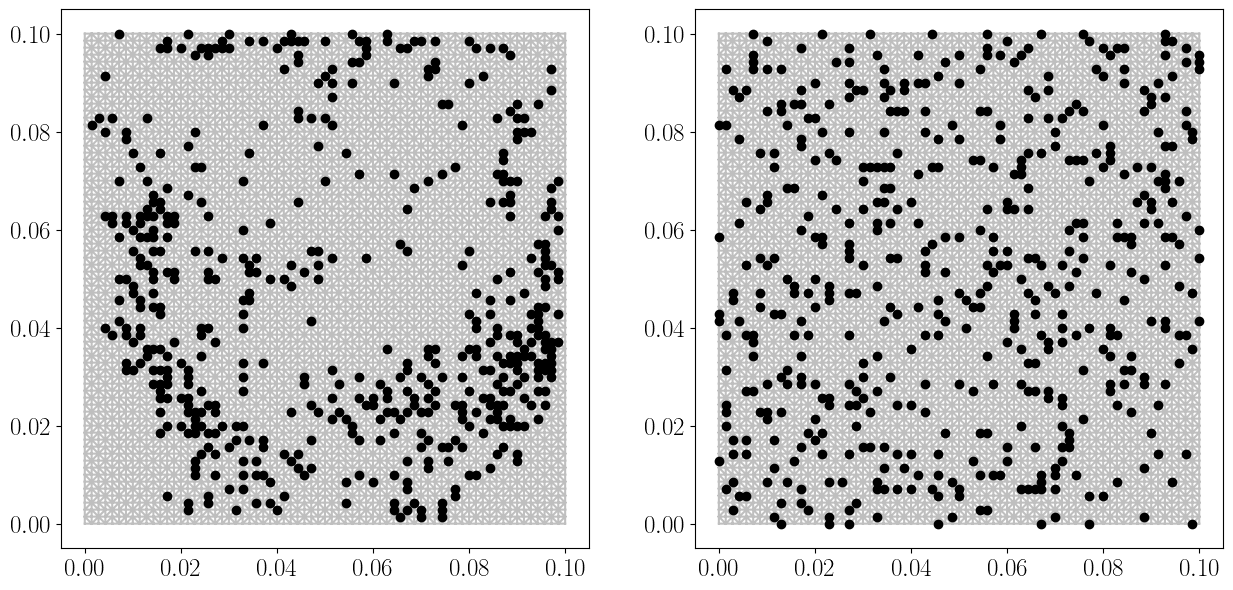

In [77]:
ind = np.random.choice(range(5041), int(0.1*5041), replace= False, p = p)
ind_unif = np.random.choice(range(5041), int(0.1*5041), replace= False)
fig,ax = plt.subplots(1,2,figsize=(15,7))
ax[0].triplot(triangulation,c='grey',alpha=0.5,zorder=-1)
ax[0].scatter(triangulation.x[ind],triangulation.y[ind],color='k')
ax[1].triplot(triangulation,c='grey',alpha=0.5,zorder=-1)
ax[1].scatter(triangulation.x[ind_unif],triangulation.y[ind_unif],color='k')

## Random

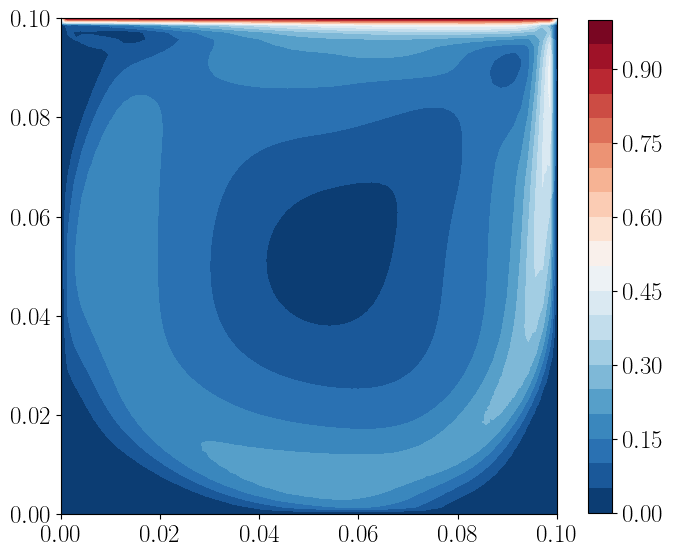

In [24]:
import matplotlib
field = cavity.data.snapshots["mag(v)"][-1]
vmin = field.min() - 0.001
vmax = field.max() + 0.001
fig,ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')
tr = ax.tricontourf(cavity.data.triang, field,levels=20)#, norm=matplotlib.colors.TwoSlopeNorm(0,vmin=vmin,vmax=vmax))
plt.colorbar(tr,shrink=0.8)
# plt.gcf().savefig("cavity_highest_re")

In [36]:
vmin, vmax

(-0.29530337, 0.26735494)

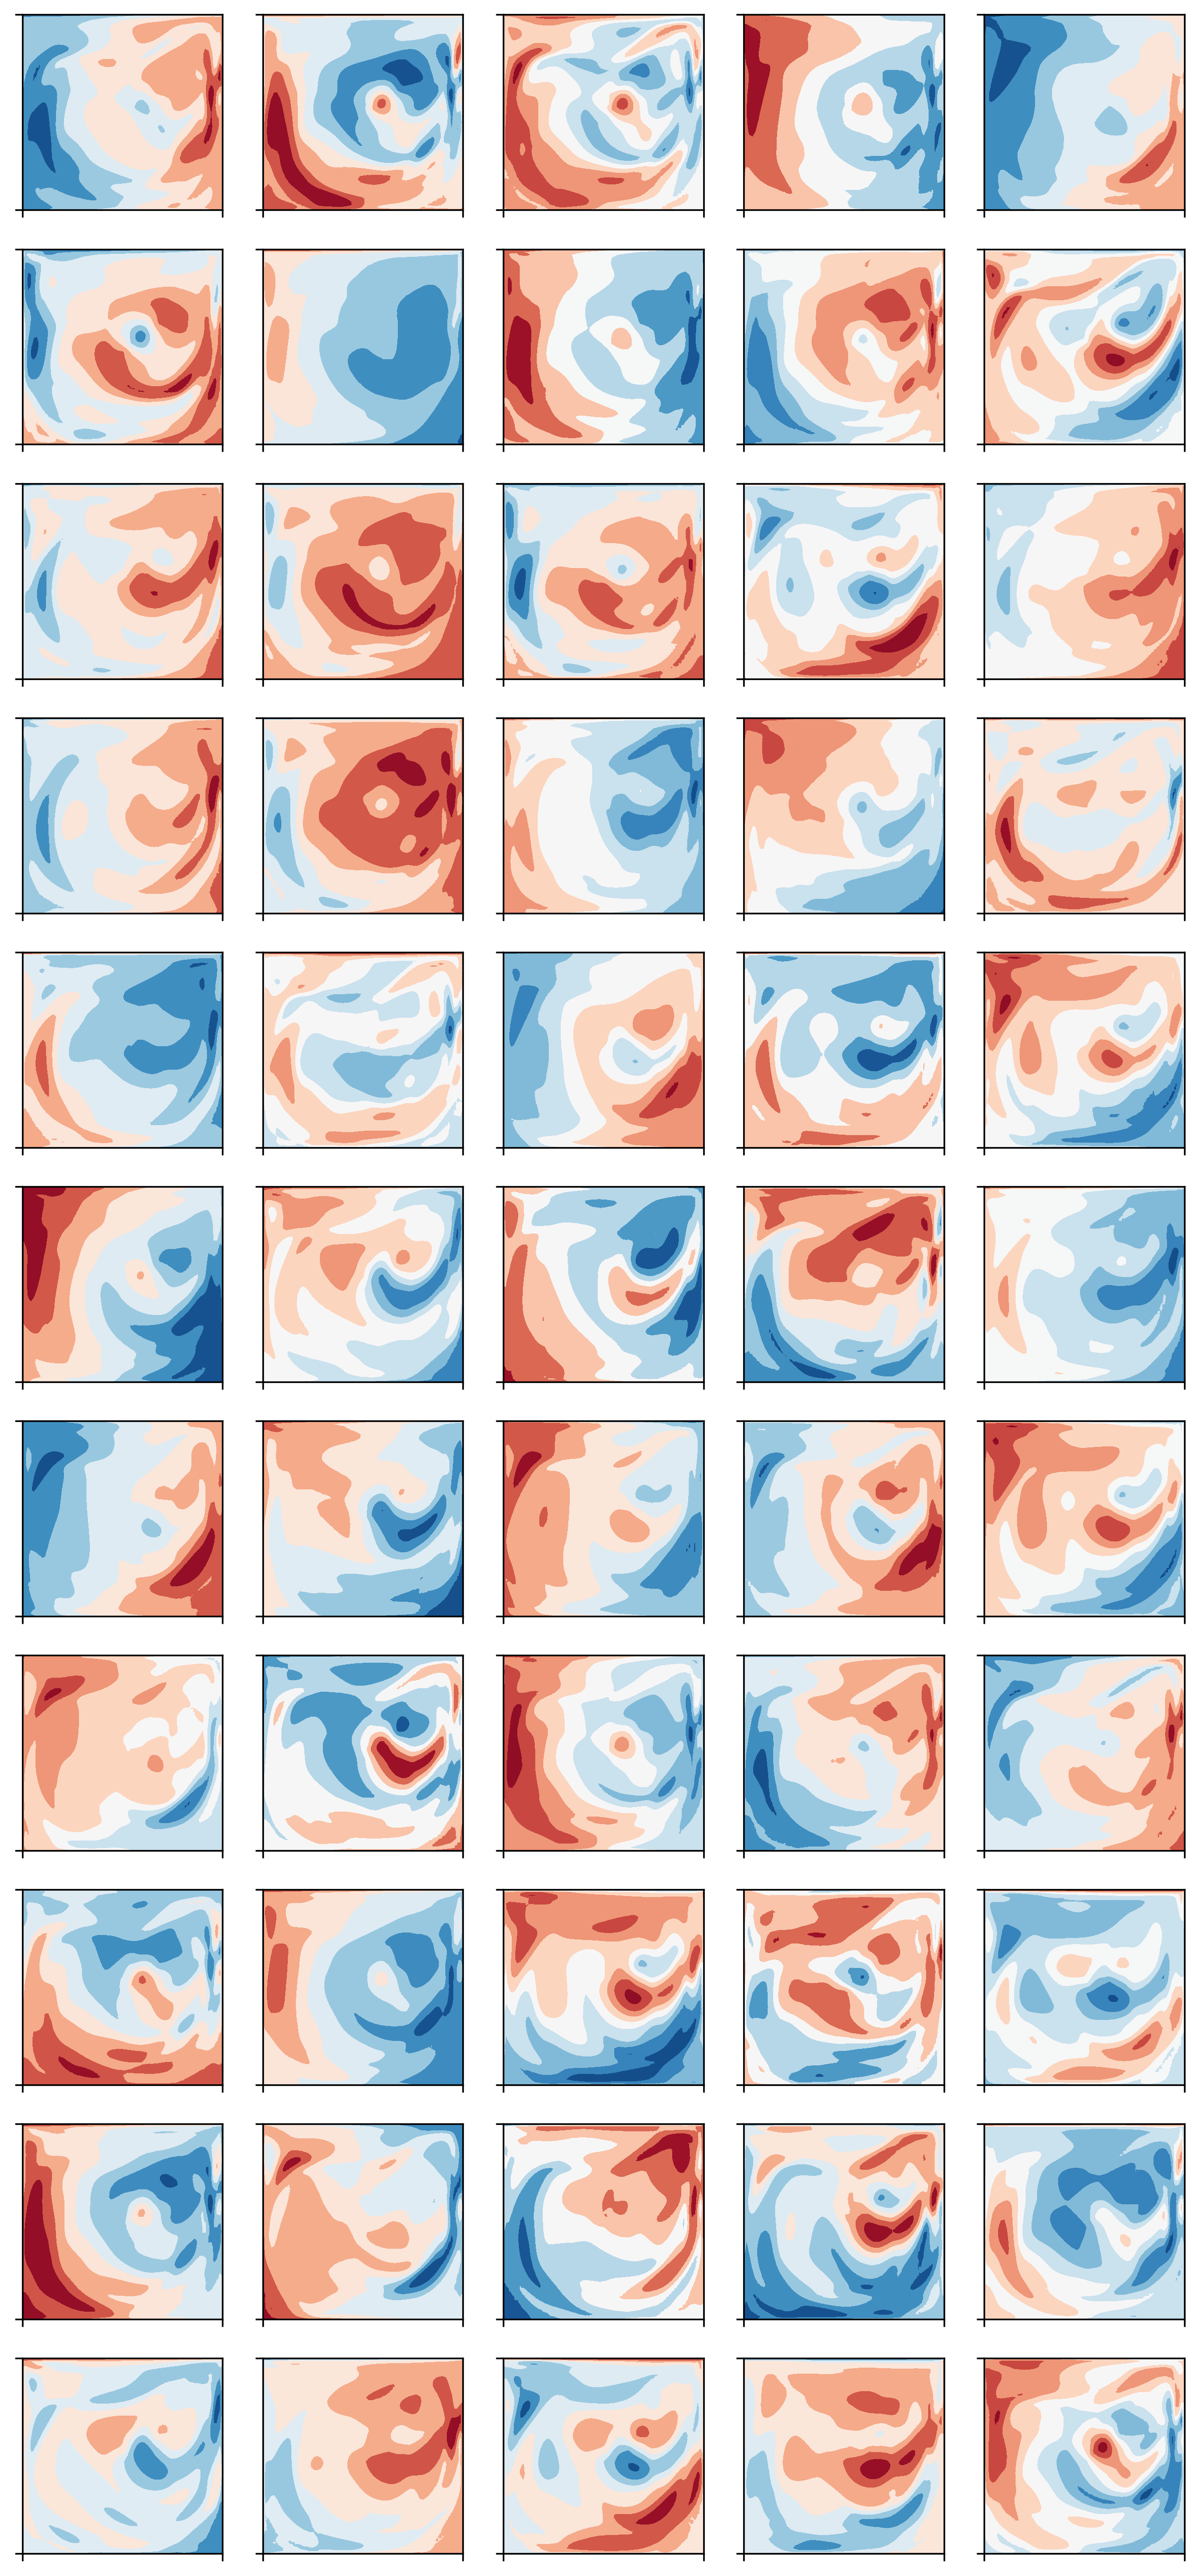

In [48]:
cnet = rom.neural_net['correction_network'].cpu()
cnet.modes = cnet.modes.cpu()
cnet.coords = cnet.coords.cpu()
c = cnet.C(torch.tensor([[0.1]])).tensor[0]
#modes = rom.neural_net['correction_network'].modes.cpu()
list_labels = [f'{i}' for i in range(0,reddim)]
list_fields = [c[:,i].detach().numpy().reshape(-1) for i in range(0,reddim*(reddim+1)//2)]
vmin = min([field.min() for field in list_fields])
vmax = max([field.max() for field in list_fields])
#plot(data.triang,list_fields,list_labels, vmin = vmin, vmax = vmax)
fig,ax = plt.subplots(11,5,figsize=(10,22),dpi=300)
for i in range(55):
    a = ax.ravel()[i]
    p = a.tricontourf(data.triang,list_fields[i])#,vmin=-0.04,vmax=0.04)
    #a.hist(list_fields[i])
    a.set_xticklabels([])
    a.set_yticklabels([])
#fig.colorbar(p)
fig.savefig('c_cols_10_10')

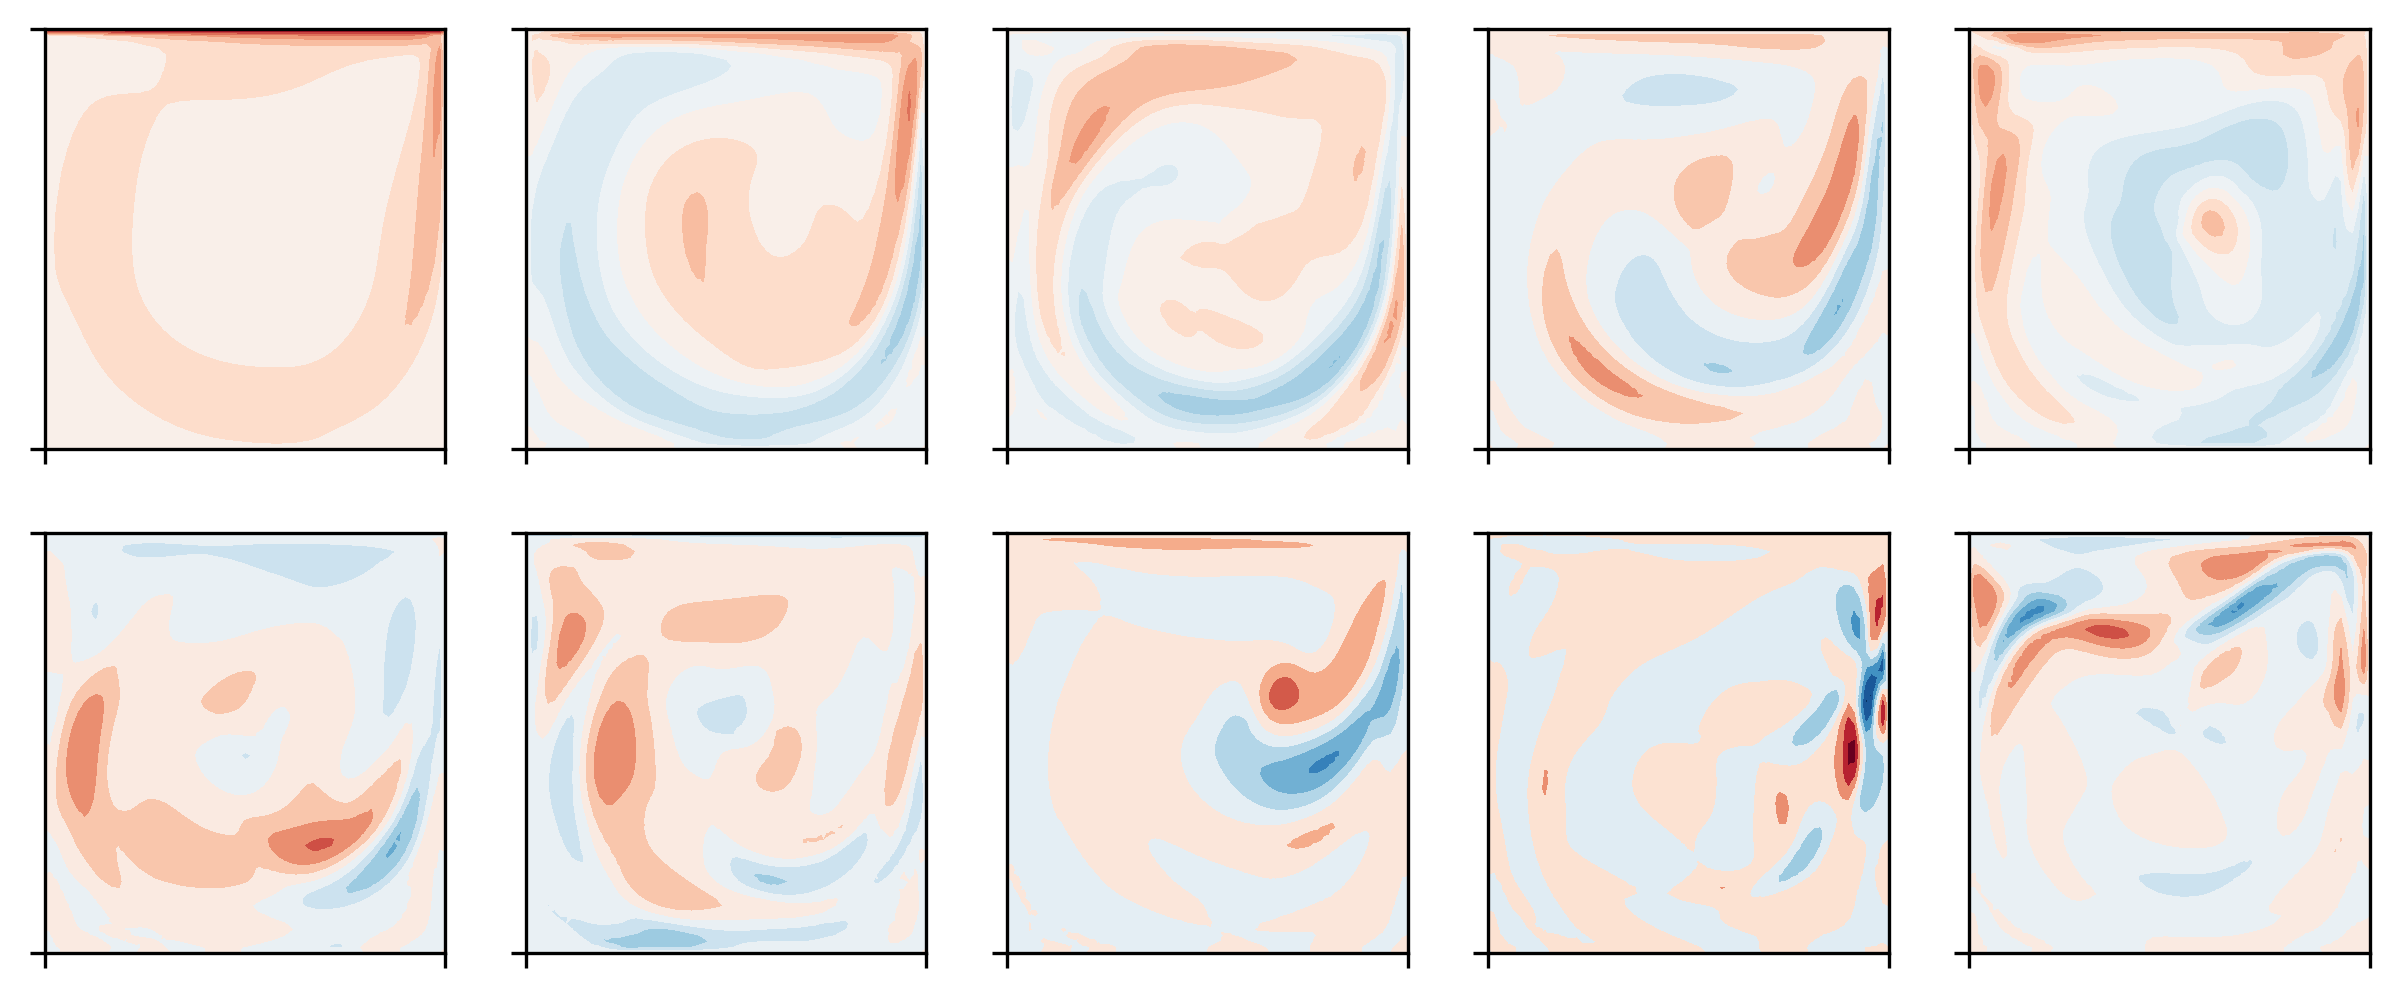

In [60]:
cnet = rom.neural_net['correction_network'].cpu()
cnet.modes = cnet.modes.cpu()
cnet.coords = cnet.coords.cpu()
modes = cnet.modes.cpu()
list_labels = [f'{i}' for i in range(0,reddim)]
list_fields = [modes[:,i].detach().numpy().reshape(-1) for i in range(0,reddim)]
vmin = min([field.min() for field in list_fields])
vmax = max([field.max() for field in list_fields])
#plot(data.triang,list_fields,list_labels, vmin = vmin, vmax = vmax)
fig,ax = plt.subplots(2,5,figsize=(10,4),dpi=300)
for i in range(10):
    a = ax.ravel()[i]
    p = a.tricontourf(data.triang,list_fields[i],norm=matplotlib.colors.TwoSlopeNorm(0,vmin=vmin,vmax=vmax))
    #a.hist(list_fields[i])
    a.set_xticklabels([])
    a.set_yticklabels([])
#fig.colorbar(p)
fig.savefig('modes_10_10')

In [49]:
all_values = np.concatenate([list_fields])
all_values.shape

(55, 5041)

In [50]:
mins = all_values.min(axis=-1)
maxs = all_values.max(axis=-1)
means = all_values.mean(axis=-1)

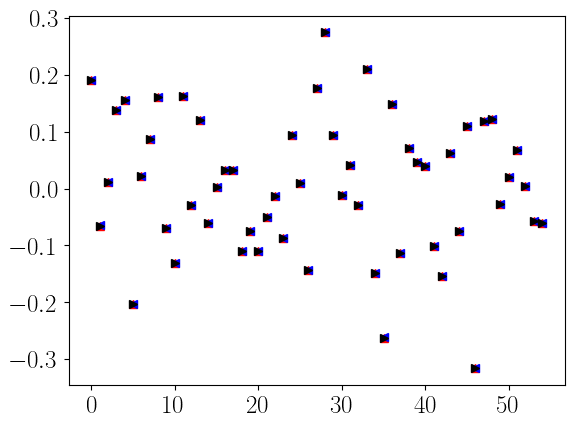

In [51]:
fig,ax = plt.subplots()
ax.plot(list(range(55)), mins, 'r^')
ax.plot(list(range(55)), maxs, 'b<')
ax.plot(list(range(55)), means, 'k>')